In [1]:
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
import h5py
from tqdm import tqdm
import time
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch import Tensor
from pathlib import Path
#Using newest versions of all libraries

# Simple CNN cluster image classifier

This notebook provides a framework for classifying cluster images from the ATLAS Open Data dataset [ATLAS simulated samples collection for jet reconstruction training](http://opendata.cern.ch/record/15010).
The dataset contains Monte-Carlo simulated samples corresponding to SM hadronic physics processes. As of now (03.20.2022) only the first part of the dataset is used for this analysis. Using the python script in this project 'cut_njets_root.py', the root file is converted into separate files containing 2D histograms. For each number of Truth Jets a category is created, and all the events associated with that number of Truth Jets is placed in the same file for easy access. Data processing is an essential part of any ML process, and this process of creating images is both naive and not necessarily physically motivated. Future work will focus on creating better images, but for now the simple histograms are used for a 'proof-of-concept' version of the code.

In [2]:
#variables controlled by the user. Change these to fit your specific needs.
VAL_PCT = 0.2 #The percentage of the data to be used as the validation set.
N_EVENTS = 9000 #Number of events to process for each class. If higher than the available number of events an exception will be raised.
MODEL_NAME = "bh_ttbar_sph-" + str(int(time.time())) #A unique name for the model
print(MODEL_NAME)

N_LABELS = [0, 1, 2] #A list containing the classes of n number of jets we wish to train for
LABELS = ["black_holes", "ttbar", "sphalerons"]
FILENAMES = ["black_holes_9996_events_n.h5", "ttbar_13TeV_pTmin1000_10000_events_n.h5", "sphalerons_10000_events_n.h5"] #Filenames should match this format


#N_LABELS = [0, 1] #A list containing the classes of n number of jets we wish to train for
#LABELS = ["black_holes", "sphalerons"]
#FILENAMES = ["black_holes_9996_events_n.h5", "sphalerons_10000_events_n.h5"] #Filenames should match this format


CLASSES = len(N_LABELS) #The number of output nodes in the net, equal to the number of classes
DATAPATH = Path("/disk/atlas3/data_MC/2dhistograms/") #The path to the folder containing the histogram files
RES = 100 #resolution

#FILENAMES = ["directW_13TeV_taus_10000events.h5", "blank_images_10000events.h5"] #Filenames should match this format
#CUDA = torch.device('cuda') #Change this to cpu if cuda is not abailable

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

bh_ttbar_sph-1659965430
Running on the GPU


In [3]:
class CalorimeterDataset(Dataset):
    #Creates tuple object used in the dataloader
    def __init__(self, images, labels):
            self.img_labels = labels
            self.images = images
            
    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.img_labels[idx]
        return image, label

def load_hd5_histogram(path:Path):
    """
    Loads the data as numpy array. Opens the file and extracts the data before closing it again.
    """
    with h5py.File(path) as f:
        print (f.keys())
        data = f["images"]
        #create array
        arr = np.array(data)[0:N_EVENTS]
        print(f"Loaded data with {len(arr)} entries of shape {np.shape(arr)}")
        #Normalise and saturate NOT WORKING I THINK:::
        print(len(arr[arr>255]), " pixels that have energies above 255")
        #arr[arr>2000] = 2000
        #arr = (arr/2000)*255
        return Tensor(arr)

def label_maker(nclasses:list, nevents:int):
    #Creates labels for the classes. The first class gets value [1, 0, .., 0], the next [0, 1, ..., 0] etc
    a = torch.zeros(nevents*len(nclasses), len(nclasses), dtype=torch.int)
    for i in range(len(nclasses)):
        for j in range(nevents):
            a[nevents*i + j][i] = 1
    return a

def load_data(input_files, data_path):
    #Loads the data files
    val_size = int(N_EVENTS*VAL_PCT)
    train_size = int(N_EVENTS*(1-VAL_PCT))
    data = [load_hd5_histogram(data_path / file) for file in input_files]
    #Partitions off training data
    Cal_train = torch.cat([item[0:train_size] for item in data]).float().to(device)
    labels_train = label_maker(N_LABELS, train_size).float().to(device)
    #Testing data
    Cal_test = torch.cat([item[(train_size):(train_size+val_size)] for item in data]).float().to(device)
    labels_test = label_maker(N_LABELS, val_size).float().to(device)
    #Check everything is ok
    print(f"Data has shape {Cal_test[0].shape}. {len(labels_train)} training images and {len(labels_test)} testing images")
    
    train_dataset = CalorimeterDataset(Cal_train, labels_train)
    test_dataset = CalorimeterDataset(Cal_test, labels_test)
    
    return train_dataset, test_dataset

### Load the data

Start by loading the data and then taking a look at it.

In [4]:
#load data
traindata, testdata = load_data(FILENAMES, DATAPATH)

<KeysViewHDF5 ['Events', 'Filters', 'Input', 'Resolution', 'images']>
Loaded data with 9000 entries of shape (9000, 100, 100, 3)
0  pixels that have energies above 255
<KeysViewHDF5 ['Events', 'Filters', 'Input', 'Resolution', 'images']>
Loaded data with 9000 entries of shape (9000, 100, 100, 3)
0  pixels that have energies above 255
<KeysViewHDF5 ['Events', 'Filters', 'Input', 'Resolution', 'images']>
Loaded data with 9000 entries of shape (9000, 100, 100, 3)
0  pixels that have energies above 255
Data has shape torch.Size([100, 100, 3]). 21600 training images and 5400 testing images


[[0, 0, 0], [1, 1, 1], [2, 2, 2]]
[[52, 34, 94], [1828, 1803, 1875], [3680, 3698, 3698]]
Image shape:  torch.Size([100, 100, 3])
[[[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, 0.0]], [[0.0, 1.0, 0.0], [0.0, 1.0, 0.0], [0.0, 1.0, 0.0]], [[0.0, 0.0, 1.0], [0.0, 0.0, 1.0], [0.0, 0.0, 1.0]]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


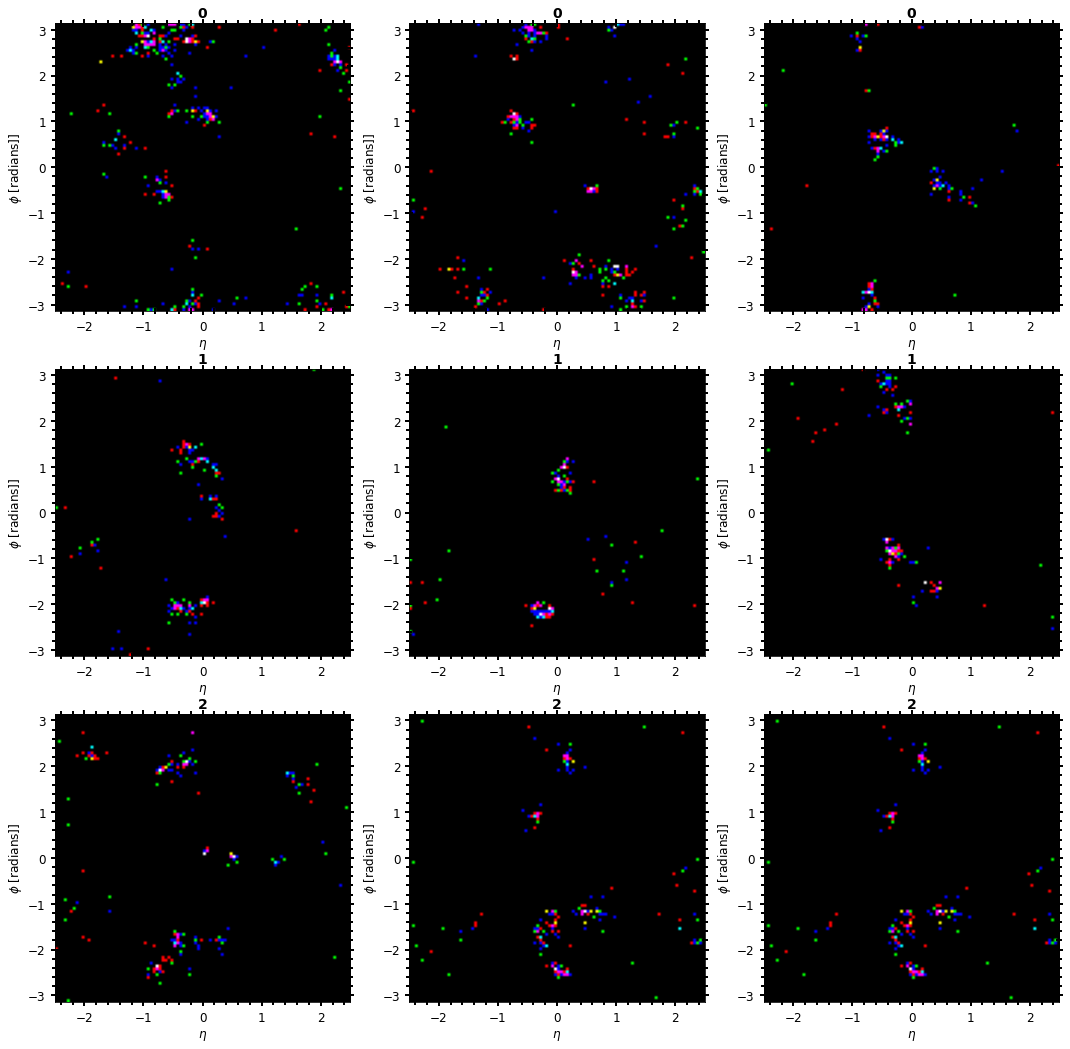

In [5]:
def cal_image_plot(ax, n_jets):
    ax.set_ylabel(r"$\phi$ [radians]]", fontsize=12)
    ax.set_xlabel(r"$\eta$", fontsize=12)
    ax.set_title(str(n_jets), fontsize=14,weight="bold")
    ax.tick_params(which="both", direction="inout", top=True, right=True, labelsize=12, pad=5, length=4, width=2)
    ax.tick_params(which="major", length=8)
    ax.tick_params(which="minor", length=6)
    ax.minorticks_on()

img_per_row = 3
k = [[i]*img_per_row for i in range(CLASSES)]
print(k)
for i in range(len(k)):
    row = k[i]
    row = [item*(N_EVENTS*(VAL_PCT)) for item in row]
    row = [int(item + np.random.randint(1, high = 100)) for item in row]
    k[i] = row
print(k)
images = [testdata.images[item].cpu() for item in k]
print("Image shape: ", images[0][0].shape)
labels = [testdata.img_labels[item].cpu() for item in k]
labels = [label.tolist() for label in labels]
print(labels) #Double check that this matches the expected values

fig, axs = plt.subplots(nrows = CLASSES, ncols = img_per_row, figsize = (img_per_row*6, CLASSES*6))
for i in range (len(k)):
    for j in range(img_per_row):
        cal_image_plot(axs[i][j], int(N_LABELS[i]))
        axs[i][j].imshow(images[i][j], extent=[-2.5, 2.5, -np.pi, np.pi], aspect='auto')


In [6]:
check = images[1][1] #torch.flatten(images[0])
check = torch.flatten(check)
print("Before sort: ", check)
#print(check)
print("After sort:", torch.sort(check, descending=True)[0][0:20])

Before sort:  tensor([0., 0., 0.,  ..., 0., 0., 0.])
After sort: tensor([255., 255., 255., 255., 255., 233., 211., 203., 180., 176., 148., 128.,
        118.,  82.,  61.,  61.,  55.,  44.,  43.,  43.])


In [7]:
testlabels = np.array(torch.argmax(testdata.img_labels, -1).cpu())
trainlabels = np.array(torch.argmax(traindata.img_labels, -1).cpu())
print(trainlabels)
print(np.count_nonzero(testlabels))
print(np.count_nonzero(trainlabels))

[0 0 0 ... 2 2 2]
3600
14400


### Create the NN and start training

We will now create the neural network architecture and the functions for training and testing our network. This is a convoluted neural network CNN. 


In [8]:
class ConvNet(nn.Module):
    #This code is heavily inspired by/copied from this tutorial; https://pythonprogramming.net/introduction-deep-learning-neural-network-pytorch/
    def __init__(self):
        super().__init__() # just run the init of parent class (nn.Module)
        self.conv1 = nn.Conv2d(3, 32, 3) # input is 3 channels, 32 output channels, 3x3 kernel / window
        self.conv2 = nn.Conv2d(32, 64, 3) # input is 32, bc the first layer output 32. Then we say the output will be 64 channels, 5x5 kernel / window
        self.conv3 = nn.Conv2d(64, 128, 3)

        x = torch.randn(RES,RES,3).view(-1, 3, RES, RES) #Dummy image used in to_linear func
        print(x.shape)
        self._to_linear = None
        self.convs(x)

        self.fc1 = nn.Linear(self._to_linear, 512) #flattening.
        self.fc2 = nn.Linear(512, CLASSES) # 512 in, CLASSES out -> number of classes

    def convs(self, x:Tensor):
        # max pooling over 2x2
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))

        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2] #calculates the output that needs to be flattened
        return x

    def forward(self, x:Tensor):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)  # .view is reshape ... this flattens X before 
        x = F.relu(self.fc1(x))
        x = self.fc2(x) # bc this is our output layer. No activation here.
        return F.softmax(x, dim=1)

In [9]:


#This code is heavily inspired by/copied from this tutorial; https://pythonprogramming.net/introduction-deep-learning-neural-network-pytorch/
def fwd_pass(net, X:Tensor, y:Tensor, train=False):
    if train:
        net.zero_grad()
    outputs = net(X.view(-1, 3, RES, RES).cuda())
    matches = [torch.argmax(i) == torch.argmax(j) for i, j in zip(outputs, y)]
    acc = matches.count(True)/len(matches)
    loss = F.cross_entropy(outputs, torch.argmax(y,dim=-1).cuda()) 
    if train:
        loss.backward()
        optimizer.step()
    return acc, loss

def test(net, data, size = 32):

    dataset = DataLoader(data, size, shuffle=True) #shuffle data and choose batch size
    X, y = next(iter(dataset)) #get a random batch
    val_acc, val_loss = fwd_pass(net, X, y)
    return val_acc, val_loss
    
def predict(net, data, size):
    #Returns the predictions (as class number values)
    dataset = DataLoader(data, size, shuffle=True) #shuffle data and choose batch size
    prediction = torch.zeros((len(dataset), size))
    truth = torch.zeros((len(dataset), size))
    i = 0
    with torch.no_grad():
        for data in tqdm(dataset):
            X, y = data
            outputs = net(X.view(-1, 3, RES, RES).cuda())
            prediction[i] = torch.argmax(outputs, dim=-1)
            truth[i] = torch.argmax(y, dim=-1)
            i = i+1
    print(i*size)
    return torch.flatten(truth), torch.flatten(prediction)

def train(net, traindata, testdata, size, epochs):
    dataset = DataLoader(traindata, size, shuffle=True)
    df_labels = ["Loss", "Accuracy", "Validation loss", "Validation accuracy", "Epoch", "Iteration"]
    df_data = [[0], [0], [0], [0], [0], [0]]
    df = pd.DataFrame(dict(zip(df_labels, df_data)))
    i = 0
    for epoch in tqdm(range(epochs)):
        for data in dataset:
            i = i+1
            X, y = data
            acc, loss = fwd_pass(net, X, y, train=True)
            #acc, loss = test(net, testdata, size=size)
            if i % 10 == 0:
                val_acc, val_loss = test(net, testdata, size=size)
                df_data = [float(loss), acc, float(val_loss), val_acc, epoch, i]
                new_df = pd.DataFrame(dict(zip(df_labels, df_data)), index=[0])
                df = pd.concat([df, new_df], ignore_index=True)
            
    return df

In [10]:
#create NN and test that nothing major is wrong.
convnet = ConvNet()
convnet.to(device = device)
testimage, testlabel = traindata.images[0], traindata.img_labels[0]
print(testimage.view(-1, 3, RES, RES).shape)
print(convnet(testimage.view(-1, 3, RES, RES).to(device)))

torch.Size([1, 3, 100, 100])
torch.Size([1, 3, 100, 100])
tensor([[0.2263, 0.3903, 0.3834]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


In [11]:
#Set learning rate, optimizer, loss function and start training
optimizer = optim.Adam(convnet.parameters(), lr=0.0001)
loss_function = nn.CrossEntropyLoss()
training_results = train(convnet, traindata, testdata, 50, 10)

100%|██████████| 10/10 [00:44<00:00,  4.49s/it]


In [12]:
print(np.shape(testimage.view(-1, 3, RES, RES)))
print(convnet(testimage.view(-1, 3, RES, RES).to(device)))

torch.Size([1, 3, 100, 100])
tensor([[1.1512e-09, 2.0310e-24, 1.0000e+00]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


### Analyzing our model
Let's take a look at the learning metrics collected in our dataframe. High accuracy on training data and low accuracy on validation implies overtraining. Low accuracy in both categories mean that the network is not learning. Next look at the loss. Loss should go down if the model is learning. If the validation loss starts going up we have overtrained. 

<AxesSubplot:xlabel='Iteration'>

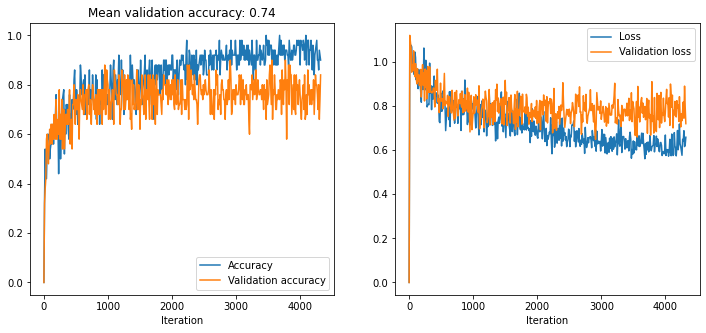

In [13]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 5))
training_results.plot("Iteration", ["Accuracy", "Validation accuracy"], ax=axs[0], 
                    title="Mean validation accuracy: " + str(round(training_results["Validation accuracy"].mean(), 2)))
training_results.plot("Iteration", ["Loss", "Validation loss"], ax=axs[1])

To further analyse our model we can check how the predictions compare to the true values. This can highlight which classes we are having trouble with.

In [14]:
truth, preds = predict(convnet, testdata, 100)
confusion = pd.DataFrame(dict(zip(["Truth", "Predictions"], [truth, preds])))
print(preds[:50])
print(truth[:50])

100%|██████████| 54/54 [00:00<00:00, 217.52it/s]

5400
tensor([1., 0., 2., 1., 0., 2., 0., 0., 1., 0., 0., 1., 1., 2., 2., 0., 2., 2.,
        2., 0., 1., 2., 1., 1., 0., 0., 2., 0., 2., 2., 2., 1., 2., 0., 2., 2.,
        1., 0., 2., 1., 2., 2., 1., 0., 0., 1., 2., 0., 0., 0.])
tensor([1., 0., 0., 1., 2., 0., 1., 0., 1., 0., 2., 1., 1., 0., 2., 0., 0., 2.,
        0., 2., 1., 2., 1., 1., 2., 1., 2., 2., 0., 2., 0., 1., 2., 1., 2., 2.,
        1., 2., 0., 1., 2., 2., 1., 0., 0., 1., 2., 0., 0., 2.])


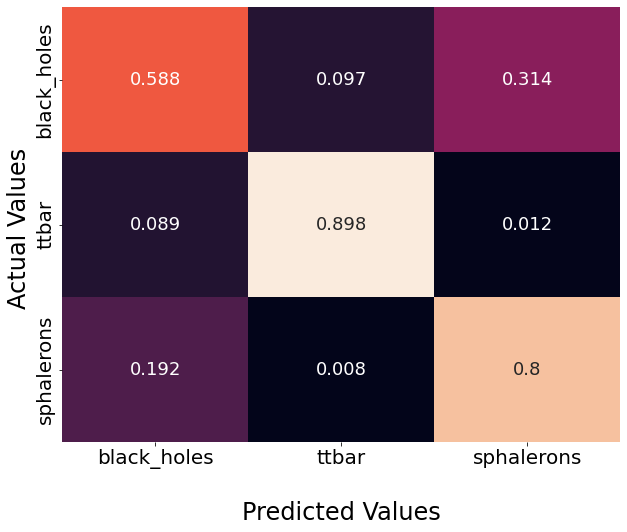

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

fig, ax = plt.subplots(figsize = (10, 8))

#Generate the confusion matrix
cf_matrix = confusion_matrix(confusion["Truth"], confusion["Predictions"], normalize="true")
cf_matrix = np.round(cf_matrix, 3)
ax = sn.heatmap(cf_matrix, annot=True, cbar=False, cmap='rocket', fmt='g',annot_kws={"size": 18})

#ax.set_title('Confusion matrix\n\n', size=24)
ax.set_xlabel('\nPredicted Values', size=24)
ax.set_ylabel('Actual Values ', size=24)

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(LABELS, size=20)
ax.yaxis.set_ticklabels(LABELS, size=20)

## Display the visualization of the Confusion Matrix.
plt.show()

In [16]:
class Block(nn.Module):
    def __init__(self, num_layers, in_channels, out_channels, identity_downsample=None, stride=1):
        assert num_layers in [18, 34, 50, 101, 152], "should be a a valid architecture"
        super(Block, self).__init__()
        self.num_layers = num_layers
        if self.num_layers > 34:
            self.expansion = 4
        else:
            self.expansion = 1
        # ResNet50, 101, and 152 include additional layer of 1x1 kernels
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(out_channels)
        if self.num_layers > 34:
            self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        else:
            # for ResNet18 and 34, connect input directly to (3x3) kernel (skip first (1x1))
            self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample

    def forward(self, x):
        identity = x
        if self.num_layers > 34:
            x = self.conv1(x)
            x = self.bn1(x)
            x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x


class ResNet(nn.Module):
    def __init__(self, num_layers, block, image_channels, num_classes):
        assert num_layers in [18, 34, 50, 101, 152], f'ResNet{num_layers}: Unknown architecture! Number of layers has ' \
                                                     f'to be 18, 34, 50, 101, or 152 '
        super(ResNet, self).__init__()
        if num_layers < 50:
            self.expansion = 1
        else:
            self.expansion = 4
        if num_layers == 18:
            layers = [2, 2, 2, 2]
        elif num_layers == 34 or num_layers == 50:
            layers = [3, 4, 6, 3]
        elif num_layers == 101:
            layers = [3, 4, 23, 3]
        else:
            layers = [3, 8, 36, 3]
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # ResNetLayers
        self.layer1 = self.make_layers(num_layers, block, layers[0], intermediate_channels=64, stride=1)
        self.layer2 = self.make_layers(num_layers, block, layers[1], intermediate_channels=128, stride=2)
        self.layer3 = self.make_layers(num_layers, block, layers[2], intermediate_channels=256, stride=2)
        self.layer4 = self.make_layers(num_layers, block, layers[3], intermediate_channels=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * self.expansion, CLASSES)
        #self.fc = nn.Linear(512, CLASSES) # 512 in, CLASSES out -> number of classes

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        return x

    def make_layers(self, num_layers, block, num_residual_blocks, intermediate_channels, stride):
        layers = []

        identity_downsample = nn.Sequential(nn.Conv2d(self.in_channels, intermediate_channels*self.expansion, kernel_size=1, stride=stride),
                                            nn.BatchNorm2d(intermediate_channels*self.expansion))
        layers.append(block(num_layers, self.in_channels, intermediate_channels, identity_downsample, stride))
        self.in_channels = intermediate_channels * self.expansion # 256
        for i in range(num_residual_blocks - 1):
            layers.append(block(num_layers, self.in_channels, intermediate_channels)) # 256 -> 64, 64*4 (256) again
        return nn.Sequential(*layers)


def ResNet18(img_channels=3, num_classes=1000):
    return ResNet(18, Block, img_channels, num_classes)


def ResNet34(img_channels=3, num_classes=1000):
    return ResNet(34, Block, img_channels, num_classes)


def ResNet50(img_channels=3, num_classes=1000):
    return ResNet(50, Block, img_channels, num_classes)


def ResNet101(img_channels=3, num_classes=1000):
    return ResNet(101, Block, img_channels, num_classes)


def ResNet152(img_channels=3, num_classes=1000):
    return ResNet(152, Block, img_channels, num_classes)



In [17]:
#create NN and test that nothing major is wrong.
resnet = ResNet18(img_channels=3, num_classes=CLASSES)
resnet.to(device = device)
optimizer = optim.Adam(resnet.parameters(), lr=0.0005)
testimage, testlabel = traindata.images[0], traindata.img_labels[0]
print(testimage.view(-1, 3, RES, RES).shape)
print(resnet(testimage.view(-1, 3, RES, RES).to(device)))

torch.Size([1, 3, 100, 100])
tensor([[ 0.6318,  0.1950, -0.1533]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


In [18]:
training_results = train(resnet, traindata, testdata, 100, 5)

100%|██████████| 5/5 [00:39<00:00,  7.80s/it]


In [19]:
k = np.random.randint(0, high=len(testdata))
print(k)
testimage, testlabel = testdata.images[k], testdata.img_labels[k]
print(testlabel)
print(np.shape(testimage.view(-1, 3, RES, RES)))
print(resnet(testimage.view(-1, 3, RES, RES).to(device)))
print(torch.argmax(resnet(testimage.view(-1, 3, RES, RES).to(device))))

###OBS DOES NOT WORK FOR JUST ONE IMAGE!!!

345
tensor([1., 0., 0.], device='cuda:0')
torch.Size([1, 3, 100, 100])
tensor([[ 1.7526, -5.0004,  0.2564]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
tensor(0, device='cuda:0')


0      0.00
1      0.71
2      0.80
3      0.78
4      0.74
       ... 
104    0.81
105    0.87
106    0.81
107    0.83
108    0.86
Name: Validation accuracy, Length: 109, dtype: float64


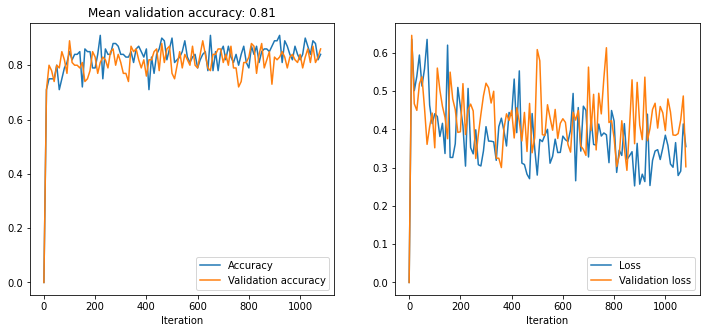

In [20]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 5))
training_results.plot("Iteration", ["Accuracy", "Validation accuracy"], ax=axs[0], 
                    title="Mean validation accuracy: " + str(round(training_results["Validation accuracy"].mean(), 2)))
training_results.plot("Iteration", ["Loss", "Validation loss"], ax=axs[1])
print(training_results["Validation accuracy"])

In [21]:
truth, preds = predict(resnet, testdata, 100)
confusion = pd.DataFrame(dict(zip(["Truth", "Predictions"], [truth, preds])))
print(len(truth), len(preds))
print(preds[0:100])
print(truth[0:100])

100%|██████████| 54/54 [00:00<00:00, 117.32it/s]

5400
5400 5400
tensor([1., 1., 2., 2., 2., 0., 1., 0., 1., 1., 1., 0., 2., 2., 0., 0., 2., 2.,
        2., 0., 1., 1., 1., 0., 2., 1., 2., 1., 1., 1., 1., 2., 2., 2., 1., 1.,
        0., 2., 1., 2., 0., 1., 1., 0., 1., 2., 1., 1., 2., 1., 1., 2., 2., 0.,
        0., 1., 2., 2., 1., 1., 1., 0., 2., 2., 0., 0., 0., 1., 2., 2., 1., 2.,
        2., 1., 1., 2., 0., 2., 0., 0., 0., 1., 2., 0., 2., 1., 1., 0., 2., 2.,
        0., 2., 0., 1., 2., 1., 2., 0., 1., 2.])
tensor([1., 2., 2., 0., 2., 0., 1., 2., 1., 1., 1., 0., 0., 2., 2., 0., 0., 2.,
        2., 0., 1., 1., 1., 2., 2., 1., 2., 1., 1., 1., 1., 2., 2., 2., 1., 1.,
        0., 0., 1., 2., 0., 1., 1., 0., 1., 0., 0., 1., 2., 1., 1., 2., 2., 0.,
        0., 1., 2., 2., 1., 1., 1., 2., 2., 2., 0., 2., 0., 1., 2., 0., 1., 2.,
        2., 0., 1., 2., 0., 2., 0., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0., 2.,
        2., 2., 0., 1., 0., 1., 2., 0., 1., 2.])


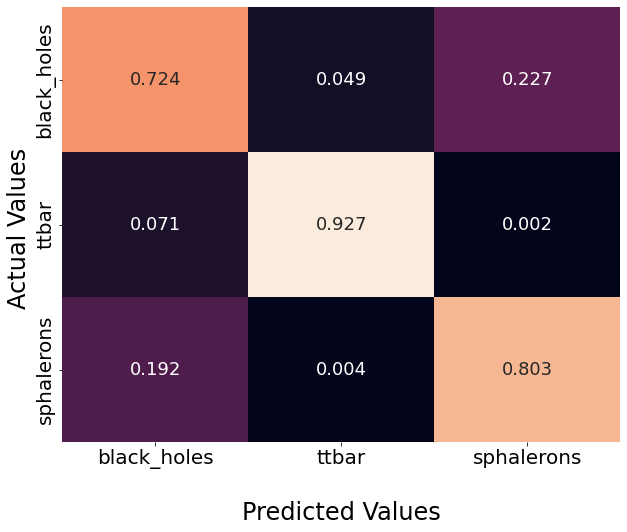

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

fig, ax = plt.subplots(figsize = (10, 8))

#Generate the confusion matrix
cf_matrix = confusion_matrix(confusion["Truth"], confusion["Predictions"], normalize="true")
cf_matrix = np.round(cf_matrix, 3)
ax = sn.heatmap(cf_matrix, annot=True, cbar=False, cmap='rocket', fmt='g',annot_kws={"size": 18})

#ax.set_title('Confusion matrix\n\n', size=24)
ax.set_xlabel('\nPredicted Values', size=24)
ax.set_ylabel('Actual Values ', size=24)

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(LABELS, size=20)
ax.yaxis.set_ticklabels(LABELS, size=20)

## Display the visualization of the Confusion Matrix.
plt.show()